# RGBChem

RGBChem is a procedure for predicting the properties of chemical compounds using the conversion of chemical properties to RGB images.

In this Jupyter Notebook we present the main ideas of the whole workflow.

## Loading python files from github (Google Colab only)

In [ ]:
!pip -q install gitpython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.8 MB/s eta 0:00:00


In [ ]:
from git import Repo

repo_path = '/content/RGBChem'

repo_url = 'https://github.com/all2gos/RGBChem.git'

Repo.clone_from(repo_url, repo_path)

!mv /content/RGBChem/* .

## Data Preparation

For the purpose of presenting a working demo, we will use a [qm9 database](https://www.nature.com/articles/sdata201422), which contains 133885 organic molecules with up to 9 heavy atoms (CONF).

In [ ]:
import pandas as pd
from scripts.dataloaders import dataloader_conv
from scripts.params import *

#this function perform database creation, .png files creation and DataLoader and Dataset PyTorch object creation. Moreover it is possible to create
#a fastai workflow build on that components which we will show you in this demo.

print(DELETE)
dl = dataloader_conv()
ds = pd.read_csv(f'{PATH}/qm9.csv')


True
Creating 133885 images for training model
Rearranging train and test files
Calibration for each spectra (based on 33.33% of data):
Calibration: 37.56%

In [ ]:
ds.drop(['cords','mulliken'],axis=1).head() #showing the initial database

,Unnamed: 0,ID,A,B,C,Dipole moment,Isotropic Polarizability,Energy of HOMO,Energy of LUMO,bandgap,...,Free energy at 298K,Heat capacity at 298K,n_atoms,atom_type,Number_of_C,Number_of_F,Number_of_N,Number_of_O,Number_of_H,Sum_of_heavy_atoms
0,15,gdb_1733_15,4.95298,1.75372,1.60123,0.5832,69.43,-0.2594,0.0529,0.3123,...,-272.573883,29.432,17,"['C', 'C', 'C', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']",7,0,0,0,10,7
1,17,gdb_408_17,6.11932,3.04137,2.41582,3.0447,50.74,-0.2483,-0.0234,0.2249,...,-286.507087,22.432,13,"['C', 'C', 'C', 'N', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H']",4,0,1,1,7,6
2,22,gdb_3688_22,7.58220,2.18673,1.71534,3.3509,48.02,-0.2620,-0.0173,0.2448,...,-376.617925,21.523,11,"['C', 'C', 'N', 'C', 'O', 'N', 'O', 'H', 'H', 'H', 'H']",3,0,2,2,4,7
3,37,gdb_1849_37,6.46026,2.15802,1.65078,3.1270,55.58,-0.2441,-0.0093,0.2348,...,-340.727945,23.305,13,"['C', 'C', 'N', 'C', 'C', 'O', 'N', 'H', 'H', 'H', 'H', 'H', 'H']",4,0,2,1,6,7
4,98,gdb_90_98,10.79571,4.78732,3.54292,2.7119,42.77,-0.2415,-0.0194,0.2222,...,-231.184401,17.076,11,"['O', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H']",4,0,0,1,6,5


### Image Creation

The whole procedure is based on the following concepts:

- We represent a molecule with $N$ atoms as a matrix of dimensions $(N+m)\times(N+m)$, where $m$ is some assumed margin that makes all generated images of the same size
- In cells where $i=j$ (i.e., on the diagonal of the matrix), we can put information about properties specific to individual atoms (e.g., atomic charge)
- In all cells we can include information describing the relationship between atom $i$ and $j$. Values for some properties are present in all cells (e.g. Coulomb charge), some are zeroes on diagonal (e.g. Cartesian distance between atoms)
- This leads us to 3 matrices that contain 3 to 6 types of different information.
- We scale all the values in the matrices so that each has values in the range $0-255$.
- In this way, we obtain 3 matrices that are direct information about the scale of each color in the RGB system -> based on this we generate the corresponding images.


One important fact should be kept in mind: a translation or rotation of a molecule does not change its energy or any other property. Still, we can generate lots of images according to the given procedure for the same molecule. We decided to use this fact to augment the data and generate many different images for the same molecule. However in this demo we do not do that.

For one matrix, it is necessary to specify parameters from ReaxFF. So far, the most accessible and efficient way is to paste them into a dictionary directly in notebook.

## Fastai approach

In [ ]:
from fastai.vision.all import *
from scripts.params import *

def get_list(path):
    l = []
    for plik in os.listdir(path):
        if os.path.isfile(os.path.join(path, plik)):
            l.append(plik)
    return l

def get_x(r): return f"{path}/{r['ID']}.png"
def get_y(r): return float(r[PREDICTED_VALUE])



path = f'{PATH}/{TRAIN_DIR_NAME}'
get_image_files = get_list(path)


In [ ]:
f = os.listdir(f"{PATH}/{TRAIN_DIR_NAME}")
f = [x[:-4] for x in f]

filtered = ds[ds.ID.isin(f)]
print(f'{len(filtered)} out of {len(ds)} samples were selected')


82974 out of 401655 samples were selected


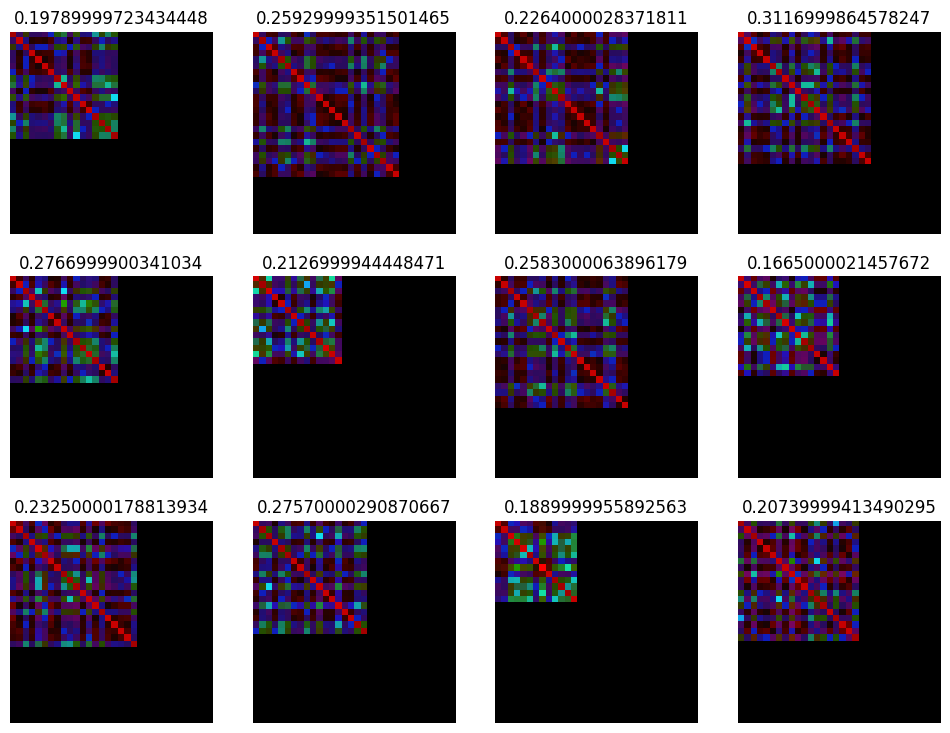

In [ ]:
dblock = DataBlock(blocks=(ImageBlock, RegressionBlock),
                   get_x=get_x, get_y=get_y,
                   splitter=RandomSplitter(valid_pct=0.1, seed=42)).dataloaders(filtered)

dblock.show_batch(max_n=12)

## Training the Model

For the demo purpose, we choose HOMO-LUMO Gap as the property to predict. And because of the simplicity and transparency of the fastai library, we use that library in this demo to carry out the machine learning workflow. We choose a very simple architecture for learning, which takes very little time to train.

In the standard workflow, we will build the model using clear PyTorch to have more control over the training process.

In [ ]:
learn = vision_learner(dblock, resnet18, metrics=mae)
learn.fine_tune(32) #~2 minutes training on T4 GPU

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 175MB/s]


epoch,train_loss,valid_loss,mae,time
0,0.013485,0.005348,0.055986,02:05


epoch,train_loss,valid_loss,mae,time
0,0.003690,0.001879,0.035046,02:23
1,0.003304,0.001861,0.034503,02:21
2,0.003244,0.002066,0.036602,02:22
3,0.003412,0.001984,0.035857,02:23
4,0.003658,0.002572,0.038410,02:16
5,0.003370,0.002282,0.038123,02:32
6,0.002990,0.002409,0.039023,02:17
7,0.002718,0.001977,0.034817,02:24
8,0.002248,0.001484,0.030983,02:26
9,0.002100,0.001815,0.033565,02:24


In [ ]:
err = []
test_files = os.listdir(f"{PATH}/{TEST_DIR_NAME}")

for idx in range(len(test_files[:400])):
    num, _, probs = learn.predict(PILImage.create(f'{PATH}/{TEST_DIR_NAME}/{test_files[idx]}'))
    actual = ds[PREDICTED_VALUE].loc[ds.ID == test_files[idx][:-4]].values[0]
    err.append(np.abs(num-float(actual)))

print(f"Average error on test files is {sum(err)/len(err)*27211} meV")


Average error on test files is [882.79516173] meV


In [ ]:
err = []
train_files = os.listdir(f"{PATH}/{TRAIN_DIR_NAME}")

for idx in range(len(train_files[:400])):
    num, _, probs = learn.predict(PILImage.create(f'{PATH}/{TRAIN_DIR_NAME}/{train_files[idx]}'))
    actual = ds[PREDICTED_VALUE].loc[ds.ID == train_files[idx][:-4]].values[0]
    err.append(np.abs(num-float(actual)))

print(f"Average error on train files is {sum(err)/len(err)*27211} meV")

Average error on train files is [425.85985408] meV


As can be seen: the accuracy of the model is not very high, but it should be remembered here that the aim here was not to create an optimal model, but only to show the workflow. Currently our best model using this procedure achieved an average accuracy of less than 0.3 eV on the test set.